# Data Viz

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('Cleaned_WITHOUT_COVID.csv')


In [2]:
df = df[['Date', 'CDX HY Spread']]

df['Date'] = pd.to_datetime(df['Date'])

df_date_index = df.set_index('Date')

c:\Users\colby\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\colby\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\colby\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\colby\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na opti

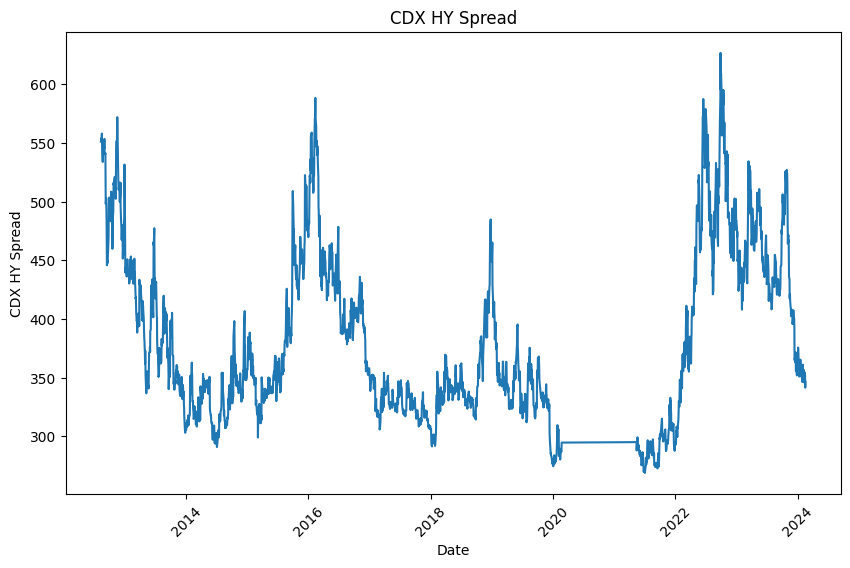

In [3]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='CDX HY Spread', data=df_date_index)
plt.title('CDX HY Spread')
plt.xticks(rotation=45)
plt.show()

# Finding Parameters of ARIMA Model

In [4]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Step 1: Check for stationarity and determine 'd'
result = adfuller(df_date_index['CDX HY Spread'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.158725
p-value: 0.221565


*Differencing is required; this p-val exceeds 0.05.*

In [15]:
# Difference the series
df_date_index['CDX HY Spread Diff-1'] = df_date_index['CDX HY Spread'].diff().notna()

# Test the differenced series for stationarity
result = adfuller(df_date_index['CDX HY Spread Diff-1'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -131709920191673.8
p-value: 0.0


c:\Users\colby\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:957: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


*We have a stationary dataset -- we can proceed with d = 1*

Text(0, 0.5, 'Autocorrelation')

<Figure size 2000x1000 with 0 Axes>

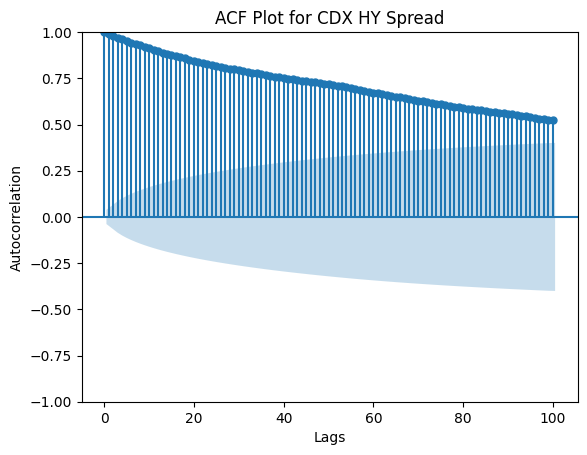

In [23]:
# Step 2: Identify 'p' and 'q' using ACF and PACF 
plt.figure(figsize=(20, 10)) 
plot_acf(df['CDX HY Spread'], lags=100, alpha=0.05)

plt.title('ACF Plot for CDX HY Spread')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')

Text(0, 0.5, 'Autocorrelation')

<Figure size 2000x1000 with 0 Axes>

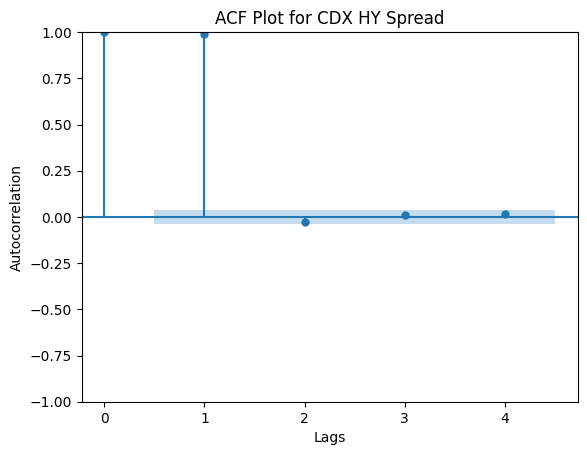

In [24]:
plt.figure(figsize=(20, 10)) 
plot_pacf(df['CDX HY Spread'], lags=4, alpha=0.05)

plt.title('ACF Plot for CDX HY Spread')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')

*Same trends as IG Spread: p = 1, q = 0*

# ARIMA(0, 1, 0) with rolling ground truths

In [30]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

train_size = int(len(df_date_index) * 0.8) 

train, test = df_date_index['CDX HY Spread'].sort_index().iloc[:train_size], df_date_index['CDX HY Spread'].sort_index().iloc[train_size:]

history = train.tolist()
predictions = []

# Rolling forecasts
for t in range(len(test)):
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test.iloc[t]) 

# Evaluate performance
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

model_fit.summary()


Test RMSE: 12.589


c:\Users\colby\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\colby\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2570
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -9401.220
Date:                Wed, 27 Mar 2024   AIC                          18804.440
Time:                        15:01:52   BIC                          18810.291
Sample:                             0   HQIC                         18806.561
                               - 2570                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        88.3320      1.191     74.147      0.000      85.997      90.667
===================================================================================
Ljung-Box (L1) (Q):                   1.38   Jarque-Bera (JB):              4689.04
Prob(Q):                              0.24   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                             0.38
Prob(H) (two-sided):                  0.21   Kurtosis:                         9.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

*The ar.L1 parameter = 0.02 indicates the 1 lag component is neglible in this series when it is differenced. ARIMA(0,1,0) is effective as a base model for predicting HY. This model effectively acts as a random walk as well*

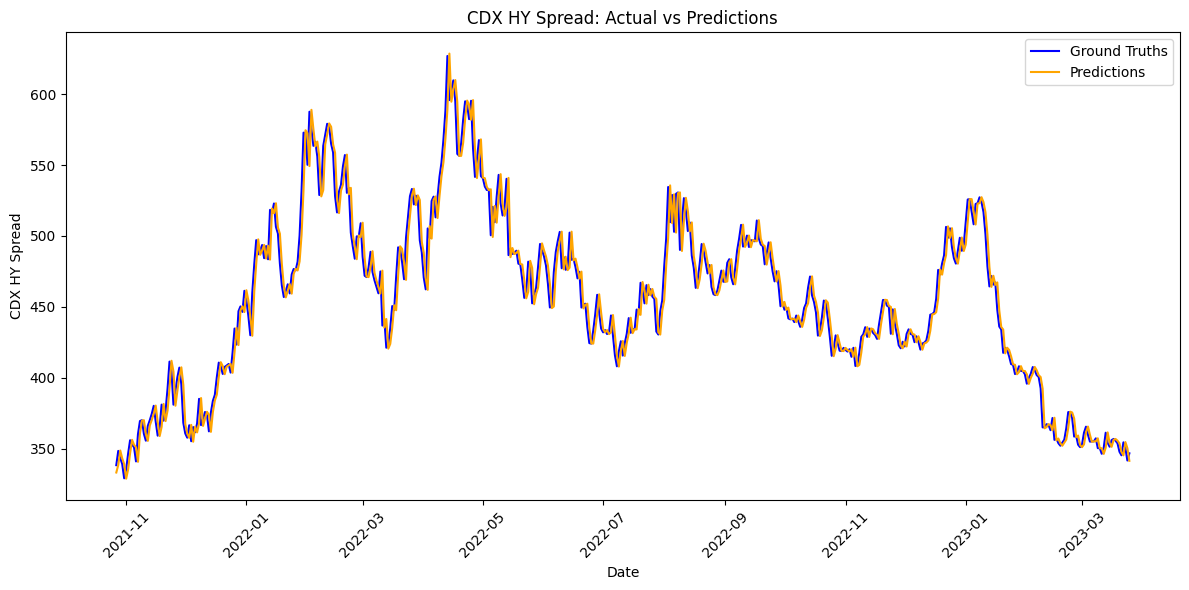

In [29]:
dates = pd.date_range(start='2021-10-27', periods=len(test), freq='D')

plt.figure(figsize=(12, 6))
plt.plot(dates, test, label='Ground Truths', color='blue')
plt.plot(dates, predictions, label='Predictions', color='orange')

plt.title('CDX HY Spread: Actual vs Predictions')
plt.xlabel('Date')
plt.ylabel('CDX HY Spread')
plt.legend()
plt.xticks(rotation=45) 
plt.tight_layout()  